# Lightweight Martian Terrain Segmentation with Explainability

This notebook demonstrates:

- Loading the AI4Mars dataset (Hugging Face: `hassanjbara/AI4MARS`).
- Training a lightweight U-Net on Martian terrain labels:
  - Classes: soil, bedrock, sand, big rock (null pixels ignored).
- Evaluating pixel accuracy and mean IoU.
- Visualizing predictions vs. ground truth.
- Explainability:
  - Grad-CAM heatmaps.
  - Integrated Gradients saliency.
  - "Neural PCA" of intermediate feature activations.


In [16]:


!pip install git+https://github.com/KellerJordan/Muon


  Cloning https://github.com/KellerJordan/Muon to /tmp/pip-req-build-og_pjxyv
  Running command git clone --filter=blob:none --quiet https://github.com/KellerJordan/Muon /tmp/pip-req-build-og_pjxyv
  Resolved https://github.com/KellerJordan/Muon to commit f90a42b28e00b8d9d2d05865fe90d9f39abcbcbd
  Preparing metadata (setup.py) ... done


In [17]:
import os
import random
from pathlib import Path

import torch
import matplotlib.pyplot as plt

from models import create_unet
from dataloader import (
    create_ai4mars_dataloaders,
    AI4MARS_CLASS_NAMES,
    AI4MARS_IGNORE_INDEX,
)
from optimizers import create_optimizer
from train_utils import train_one_epoch, evaluate
from explainability import grad_cam, integrated_gradients, neural_pca

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

image_size = 256
batch_size = 4
num_workers = 4
num_classes = len(AI4MARS_CLASS_NAMES)
num_epochs = 15

learning_rate = 2e-4
weight_decay = 1e-2
use_muon = True       # will fall back to AdamW if Muon isn't installed
use_amp = True        # mixed precision if CUDA available

out_dir = Path("./outputs")
out_dir.mkdir(exist_ok=True, parents=True)

seed = 42
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


Using device: cuda


In [18]:
# Data: AI4Mars dataloaders (train/val/test)
loaders = create_ai4mars_dataloaders(
    batch_size=batch_size,
    image_size=image_size,
    num_workers=num_workers,
    val_fraction=0.1,
    to_rgb=False,
    seed=seed,
    cache_dir="./data/hf_cache",   # explicit cache folder
    max_train_samples=100,         # tiny subset for debugging
    max_val_samples=50,
    max_test_samples=50,
    use_local_disk_copy=True,
    local_disk_path="./data/ai4mars_hf_on_disk",
)

train_loader = loaders.train
val_loader = loaders.val
test_loader = loaders.test

print(
    f"Train batches: {len(train_loader)}, "
    f"Val batches: {len(val_loader)}, "
    f"Test batches: {len(test_loader)}"
)


Train batches: 25, Val batches: 13, Test batches: 13


In [19]:
# Model & optimizer
model = create_unet(
    in_channels=1,
    num_classes=num_classes,
    base_channels=32,  # adjust for lighter/heavier model
    bilinear=True,
)
model.to(device)

optimizer = create_optimizer(
    model,
    lr=learning_rate,
    weight_decay=weight_decay,
    use_muon=False,
)


[optimizers] Using AdamW optimizer.


In [20]:
# Training loop
history = {
    "train_loss": [],
    "train_miou": [],
    "val_loss": [],
    "val_miou": [],
}

for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs}")

    train_metrics = train_one_epoch(
        model=model,
        dataloader=train_loader,
        optimizer=optimizer,
        device=device,
        num_classes=num_classes,
        use_amp=use_amp,
    )
    val_metrics = evaluate(
        model=model,
        dataloader=val_loader,
        device=device,
        num_classes=num_classes,
    )

    history["train_loss"].append(train_metrics["loss"])
    history["train_miou"].append(train_metrics["miou"])
    history["val_loss"].append(val_metrics["loss"])
    history["val_miou"].append(val_metrics["miou"])

    print(
        f"  Train - loss: {train_metrics['loss']:.4f}, "
        f"mIoU: {train_metrics['miou']:.4f}, "
        f"pix acc: {train_metrics['pixel_acc']:.4f}"
    )
    print(
        f"  Val   - loss: {val_metrics['loss']:.4f}, "
        f"mIoU: {val_metrics['miou']:.4f}, "
        f"pix acc: {val_metrics['pixel_acc']:.4f}"
    )



Epoch 1/15
  Train - loss: 1.1337, mIoU: 0.1965, pix acc: 0.5548
  Val   - loss: 1.3204, mIoU: 0.1165, pix acc: 0.3695

Epoch 2/15
  Train - loss: 1.0144, mIoU: 0.2370, pix acc: 0.6078
  Val   - loss: 1.3204, mIoU: 0.1309, pix acc: 0.4019

Epoch 3/15
  Train - loss: 0.9307, mIoU: 0.2670, pix acc: 0.6473
  Val   - loss: 0.9397, mIoU: 0.2665, pix acc: 0.6610

Epoch 4/15
  Train - loss: 0.8789, mIoU: 0.3234, pix acc: 0.6967
  Val   - loss: 0.9333, mIoU: 0.2914, pix acc: 0.6565

Epoch 5/15
  Train - loss: 0.8832, mIoU: 0.3028, pix acc: 0.6599
  Val   - loss: 1.1082, mIoU: 0.2668, pix acc: 0.5898

Epoch 6/15
  Train - loss: 0.7597, mIoU: 0.3401, pix acc: 0.7433
  Val   - loss: 0.9374, mIoU: 0.3778, pix acc: 0.7445

Epoch 7/15
  Train - loss: 0.7546, mIoU: 0.3497, pix acc: 0.7262
  Val   - loss: 0.9918, mIoU: 0.3323, pix acc: 0.6692

Epoch 8/15
  Train - loss: 0.7498, mIoU: 0.3736, pix acc: 0.7526
  Val   - loss: 0.7230, mIoU: 0.3966, pix acc: 0.7530

Epoch 9/15
  Train - loss: 0.7788, mIoU

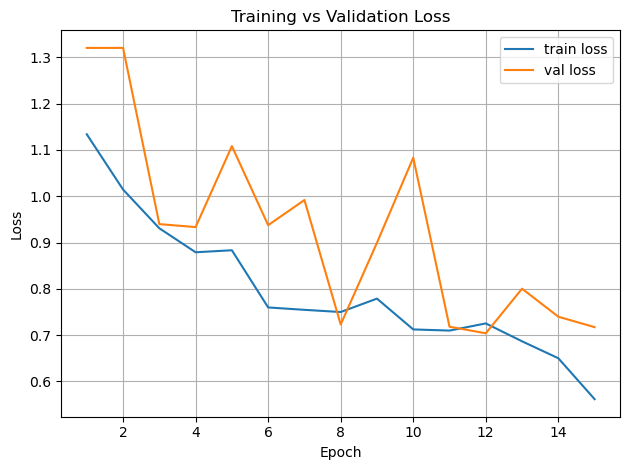

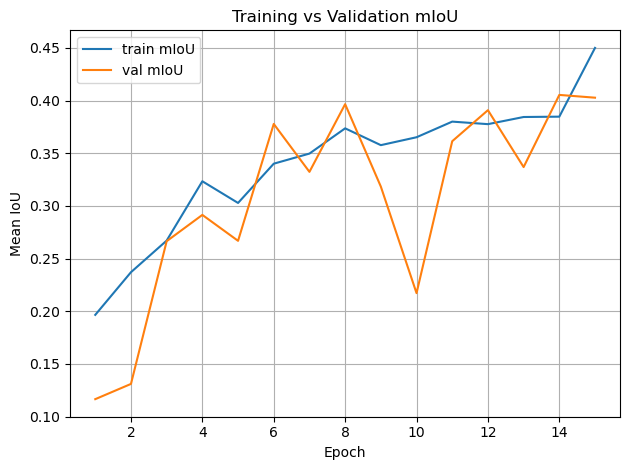

In [21]:
# Plot training curves
epochs = range(1, num_epochs + 1)

plt.figure()
plt.plot(epochs, history["train_loss"], label="train loss")
plt.plot(epochs, history["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(epochs, history["train_miou"], label="train mIoU")
plt.plot(epochs, history["val_miou"], label="val mIoU")
plt.xlabel("Epoch")
plt.ylabel("Mean IoU")
plt.legend()
plt.title("Training vs Validation mIoU")
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
# Evaluate on test set
test_metrics = evaluate(
    model=model,
    dataloader=test_loader,
    device=device,
    num_classes=num_classes,
)

print("\nTest metrics:")
print(
    f"  loss: {test_metrics['loss']:.4f}, "
    f"mIoU: {test_metrics['miou']:.4f}, "
    f"pix acc: {test_metrics['pixel_acc']:.4f}"
)



Test metrics:
  loss: 0.5712, mIoU: 0.4380, pix acc: 0.8146


/tmp/ipykernel_9963/3601530549.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


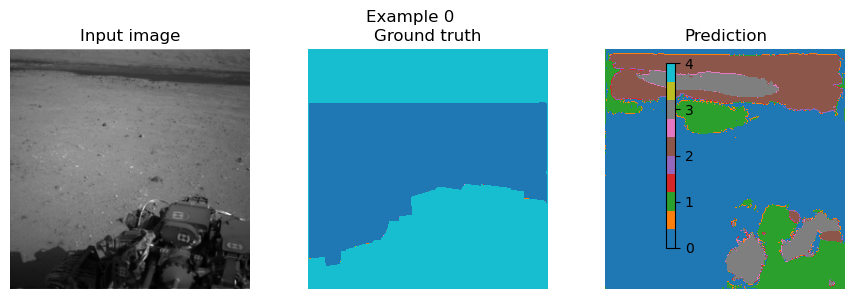

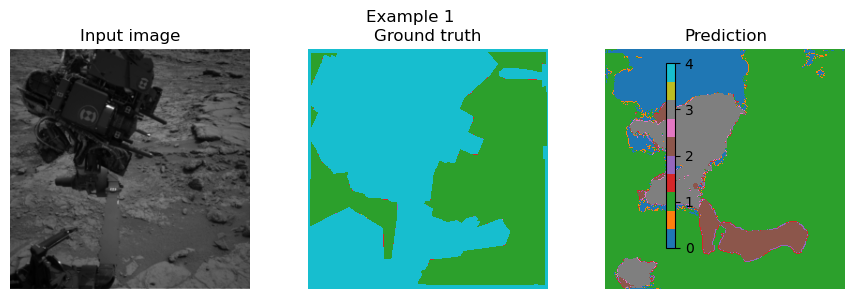

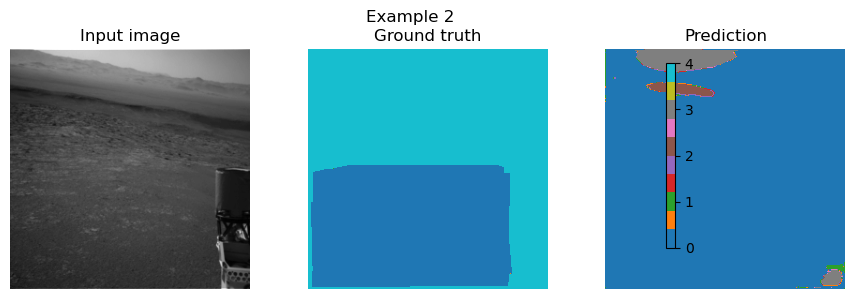

In [23]:
# Helper: visualize predictions vs ground truth
def decode_mask(mask_tensor):
    """Convert a [H,W] mask with indices into a numpy array for plotting."""
    mask_np = mask_tensor.cpu().numpy()
    return mask_np


def show_predictions(model, dataloader, num_examples: int = 3):
    model.eval()
    imgs, masks = next(iter(dataloader))

    imgs = imgs.to(device)
    masks = masks.to(device)

    with torch.no_grad():
        logits = model(imgs)
        preds = logits.argmax(dim=1)

    for i in range(min(num_examples, imgs.size(0))):
        img = imgs[i, 0].cpu().numpy()  # [H,W]
        gt = decode_mask(masks[i])
        pred = decode_mask(preds[i])

        fig, axes = plt.subplots(1, 3, figsize=(9, 3))
        axes[0].imshow(img, cmap="gray")
        axes[0].set_title("Input image")
        axes[0].axis("off")

        im1 = axes[1].imshow(gt, vmin=0, vmax=num_classes, cmap="tab10")
        axes[1].set_title("Ground truth")
        axes[1].axis("off")

        im2 = axes[2].imshow(pred, vmin=0, vmax=num_classes, cmap="tab10")
        axes[2].set_title("Prediction")
        axes[2].axis("off")

        fig.colorbar(im2, ax=axes.ravel().tolist(), shrink=0.8)
        plt.suptitle(f"Example {i}")
        plt.tight_layout()
        plt.show()


show_predictions(model, test_loader, num_examples=3)


In [24]:
# Explainability demo:
# Grad-CAM, Integrated Gradients, Neural PCA for a single test image.

model.eval()
cam_layer = model.get_cam_layer()

# Grab a single batch and pick the first sample
imgs, masks = next(iter(test_loader))
imgs = imgs.to(device)
masks = masks.to(device)

input_img = imgs[0:1]      
target_mask = masks[0]     

# Choose a target class to inspect visually (e.g. bedrock)
target_class_name = "bedrock"
target_class = AI4MARS_CLASS_NAMES.index(target_class_name)

print(f"Explaining class '{target_class_name}' (id={target_class})")

# Grad-CAM
cam_map = grad_cam(
    model=model,
    input_tensor=input_img,
    target_class=target_class,
    target_layer=cam_layer,
)  

# Integrated Gradients
ig_attr = integrated_gradients(
    model=model,
    input_tensor=input_img,
    target_class=target_class,
    baseline=torch.zeros_like(input_img),
    steps=32,
)  
# Neural PCA on the same CAM layer features
activations = {}

def hook_activations(module, inp, out):
    activations["feat"] = out.detach().cpu()

handle = cam_layer.register_forward_hook(hook_activations)
with torch.no_grad():
    _ = model(input_img)
handle.remove()

feat_map = activations["feat"]  
pcs, eigvals = neural_pca(feat_map, n_components=3) 


Explaining class 'bedrock' (id=1)


NameError: name 'explain_per_class_examples' is not defined